In [120]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [89]:
df = pd.read_csv('mobil_listrik_vector_pseudolabel.csv')  # Replace with your file path
df = df.dropna()
X = df['text_cleaning']
map_sentiment = {'positif': 2, 'netral': 1, 'negatif': 0}
y = df['sentimen'].map(map_sentiment)

In [91]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.1, random_state=42)
# show len
print('Train data:', len(X_train))
print('Test data:', len(X_test))

Train data: 1362
Test data: 152


# Traditional ML

In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Result

In [114]:
config = {
    'vectorizer': 'tfidf',  # Choose 'tfidf' or 'count'
    'vectorizer_params': {'max_features': 5000},  # Additional parameters for vectorizer
    'model_params': {},  # Additional parameters for models
}

model_dict = {
    'xgboost': xgb.XGBClassifier(objective='multi:softmax', num_class=3, **config['model_params'], class_weight='balanced'),
    'randomforest': RandomForestClassifier(**config['model_params'], class_weight='balanced'),
    'svm': SVC(**config['model_params']),
    'logreg': LogisticRegression(**config['model_params']),
    'lightgbm': lgb.LGBMClassifier(**config['model_params'], class_weight='balanced'),
}

In [94]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

vectorizer = TfidfVectorizer(**config['vectorizer_params'])

# List to store results and a dictionary to store predictions
results = []
predictions_dict = {}

# Iterate through the models and evaluate them
for model_name, model in model_dict.items():
    # Create the pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model),
    ])
    
    # Perform cross-validation for different metrics on the training set
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
    mean_f1_score = np.mean(f1_scores)
    
    accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy_score = np.mean(accuracy_scores)
    
    precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision_weighted')
    mean_precision_score = np.mean(precision_scores)
    
    recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall_weighted')
    mean_recall_score = np.mean(recall_scores)
    
    # Fit the model on the full training set
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Store predictions in the dictionary
    predictions_dict[model_name] = y_pred
    
    # Compute metrics on the test set
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    
    # Append the results (train and test metrics)
    results.append({
        'model': model_name,
        'train_f1': mean_f1_score,
        'train_accuracy': mean_accuracy_score,
        'train_precision': mean_precision_score,
        'train_recall': mean_recall_score,
        'test_f1': test_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall
    })

# Print the results in a table format
print(f"{'Model':<15} {'Train F1':<10} {'Train Acc':<10} {'Train Prec':<10} {'Train Recall':<10} {'Test F1':<10} {'Test Acc':<10} {'Test Prec':<10} {'Test Recall':<10}")
for result in results:
    print(f"{result['model']:<15} {result['train_f1']:.4f}    {result['train_accuracy']:.4f}   {result['train_precision']:.4f}    {result['train_recall']:.4f}    "
          f"{result['test_f1']:.4f}    {result['test_accuracy']:.4f}   {result['test_precision']:.4f}    {result['test_recall']:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2476
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features: 149
[LightGBM] [Info] Start training from score -0.566527
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -1.074121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [113]:
import json
# make array serializeable
# for key, value in predictions_dict.items():
#     predictions_dict[key] = value.tolist()

# Save the predictions to a JSON file
with open('predictions_ml_ori.json', 'w') as f:
    json.dump(predictions_dict, f)

# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('results_ml_ori.csv', index=False)

# BERT 

In [129]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from datasets import Dataset

In [130]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels=3)

def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_train, y_train, test_size=0.111, random_state=42)

print('Train data:', len(X_train_bert))
print('Val data:', len(X_val_bert))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train data: 1210
Val data: 152


In [131]:
X_train_tokenized = tokenize_function(list(X_train_bert))
X_val_tokenized = tokenize_function(list(X_val_bert))

# Convert labels to lists of integers
y_train_list = y_train_bert.tolist()
y_val_list = y_val_bert.tolist()

In [132]:
train_dataset = Dataset.from_dict({
    'input_ids': [ids.tolist() for ids in X_train_tokenized['input_ids']],  # Convert tensors to lists
    'attention_mask': [mask.tolist() for mask in X_train_tokenized['attention_mask']],  # Convert tensors to lists
    'labels': y_train_list
})

eval_dataset = Dataset.from_dict({
    'input_ids': [ids.tolist() for ids in X_val_tokenized['input_ids']],  # Convert tensors to lists
    'attention_mask': [mask.tolist() for mask in X_val_tokenized['attention_mask']],  # Convert tensors to lists
    'labels': y_val_list
})

In [133]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [135]:
# Training arguments, specifying batch size, number of epochs, etc.
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_strategy="epoch",  # Save model checkpoints at the end of each epoch
    load_best_model_at_end=True,  # Automatically load the best model at the end
)

# Move the model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Initialize Trainer with the model, training arguments, datasets, and compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [136]:
# Train the model
trainer.train()

  0%|          | 0/2280 [00:00<?, ?it/s]

{'loss': 0.8517, 'grad_norm': 60.50837707519531, 'learning_rate': 4.666666666666667e-05, 'epoch': 1.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.7309429049491882, 'eval_accuracy': 0.7039473684210527, 'eval_f1': 0.6725463273144356, 'eval_precision': 0.6448009668031371, 'eval_recall': 0.7039473684210527, 'eval_runtime': 1.2007, 'eval_samples_per_second': 126.588, 'eval_steps_per_second': 15.823, 'epoch': 1.0}
{'loss': 0.5825, 'grad_norm': 41.9429817199707, 'learning_rate': 4.3333333333333334e-05, 'epoch': 2.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.8100012540817261, 'eval_accuracy': 0.7171052631578947, 'eval_f1': 0.7032347422035565, 'eval_precision': 0.6947859771008067, 'eval_recall': 0.7171052631578947, 'eval_runtime': 1.1985, 'eval_samples_per_second': 126.823, 'eval_steps_per_second': 15.853, 'epoch': 2.0}
{'loss': 0.3848, 'grad_norm': 0.871314287185669, 'learning_rate': 4e-05, 'epoch': 3.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.9888932108879089, 'eval_accuracy': 0.7368421052631579, 'eval_f1': 0.7133605535338727, 'eval_precision': 0.6997481404764145, 'eval_recall': 0.7368421052631579, 'eval_runtime': 1.2337, 'eval_samples_per_second': 123.209, 'eval_steps_per_second': 15.401, 'epoch': 3.0}
{'loss': 0.2375, 'grad_norm': 0.06851114332675934, 'learning_rate': 3.6666666666666666e-05, 'epoch': 4.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.620076060295105, 'eval_accuracy': 0.7171052631578947, 'eval_f1': 0.7017250541030924, 'eval_precision': 0.6946356275303643, 'eval_recall': 0.7171052631578947, 'eval_runtime': 1.2446, 'eval_samples_per_second': 122.132, 'eval_steps_per_second': 15.266, 'epoch': 4.0}
{'loss': 0.1668, 'grad_norm': 0.0370912067592144, 'learning_rate': 3.3333333333333335e-05, 'epoch': 5.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.7175798416137695, 'eval_accuracy': 0.7039473684210527, 'eval_f1': 0.7043922907968575, 'eval_precision': 0.7054441521914633, 'eval_recall': 0.7039473684210527, 'eval_runtime': 1.2197, 'eval_samples_per_second': 124.625, 'eval_steps_per_second': 15.578, 'epoch': 5.0}
{'loss': 0.1188, 'grad_norm': 41.41301345825195, 'learning_rate': 3e-05, 'epoch': 6.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.7607157230377197, 'eval_accuracy': 0.7697368421052632, 'eval_f1': 0.7457396758736379, 'eval_precision': 0.7623843151456624, 'eval_recall': 0.7697368421052632, 'eval_runtime': 1.2035, 'eval_samples_per_second': 126.299, 'eval_steps_per_second': 15.787, 'epoch': 6.0}


KeyboardInterrupt: 

In [118]:
# Retrieve the training and evaluation logs
train_loss_values = trainer.state.log_history
train_loss = [x['loss'] for x in train_loss_values if 'loss' in x]
eval_loss = [x['eval_loss'] for x in train_loss_values if 'eval_loss' in x]
train_accuracy = [x['train_accuracy'] for x in train_loss_values if 'train_accuracy' in x]  # Custom logged training accuracy
eval_accuracy = [x['eval_accuracy'] for x in train_loss_values if 'eval_accuracy' in x]

# Create the plot for training and validation loss and accuracy
epochs = range(1, len(train_loss) + 1)

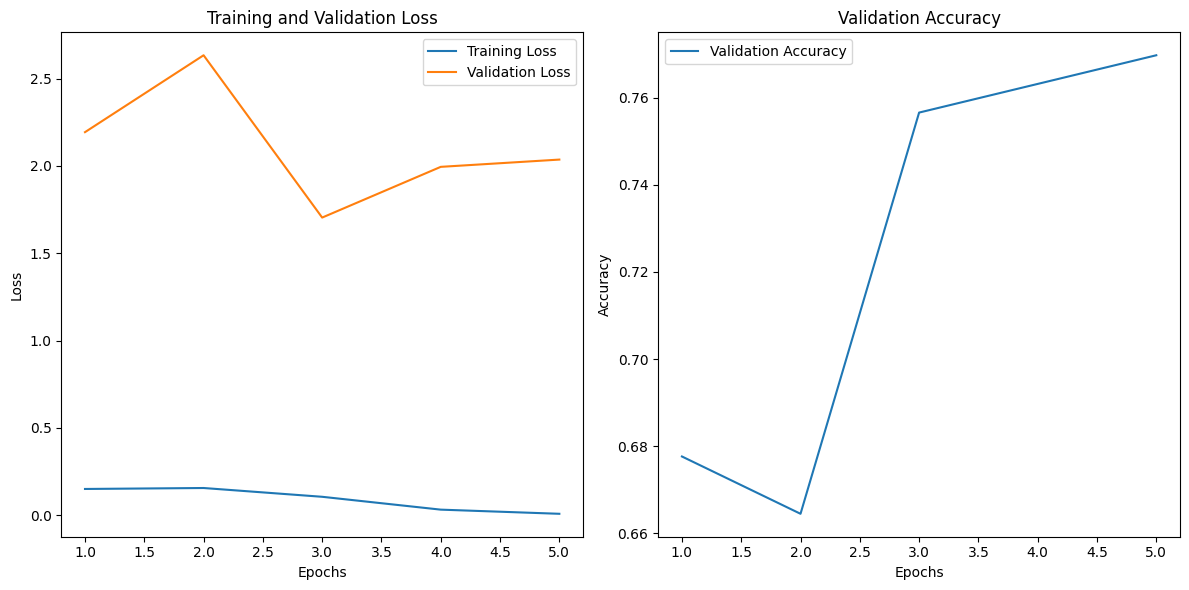

In [121]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [110]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Use 'eval_strategy' in future versions
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

# Move the model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Use Huggingface's Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

  0%|          | 0/760 [00:00<?, ?it/s]

{'loss': 0.8617, 'grad_norm': 47.028038024902344, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.8264140486717224, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.6106526478798622, 'eval_precision': 0.6313230994152047, 'eval_recall': 0.631578947368421, 'eval_runtime': 1.2545, 'eval_samples_per_second': 121.163, 'eval_steps_per_second': 15.145, 'epoch': 1.0}
{'loss': 0.5498, 'grad_norm': 69.61203002929688, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.7540877461433411, 'eval_accuracy': 0.7368421052631579, 'eval_f1': 0.7174865823537059, 'eval_precision': 0.7186380872129767, 'eval_recall': 0.7368421052631579, 'eval_runtime': 1.2127, 'eval_samples_per_second': 125.338, 'eval_steps_per_second': 15.667, 'epoch': 2.0}
{'loss': 0.2641, 'grad_norm': 0.15904687345027924, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.2714046239852905, 'eval_accuracy': 0.7105263157894737, 'eval_f1': 0.706668190326934, 'eval_precision': 0.7031774916013438, 'eval_recall': 0.7105263157894737, 'eval_runtime': 1.2572, 'eval_samples_per_second': 120.903, 'eval_steps_per_second': 15.113, 'epoch': 3.0}
{'loss': 0.1325, 'grad_norm': 0.01548162940889597, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5487794876098633, 'eval_accuracy': 0.7368421052631579, 'eval_f1': 0.7206778823064102, 'eval_precision': 0.7206697298802561, 'eval_recall': 0.7368421052631579, 'eval_runtime': 1.2231, 'eval_samples_per_second': 124.276, 'eval_steps_per_second': 15.535, 'epoch': 4.0}
{'loss': 0.0313, 'grad_norm': 0.011891782283782959, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.4958992004394531, 'eval_accuracy': 0.75, 'eval_f1': 0.7533178524894382, 'eval_precision': 0.759915080253826, 'eval_recall': 0.75, 'eval_runtime': 1.3121, 'eval_samples_per_second': 115.843, 'eval_steps_per_second': 14.48, 'epoch': 5.0}
{'train_runtime': 193.6529, 'train_samples_per_second': 31.241, 'train_steps_per_second': 3.925, 'train_loss': 0.3678650699163738, 'epoch': 5.0}


TrainOutput(global_step=760, training_loss=0.3678650699163738, metrics={'train_runtime': 193.6529, 'train_samples_per_second': 31.241, 'train_steps_per_second': 3.925, 'total_flos': 397959044313600.0, 'train_loss': 0.3678650699163738, 'epoch': 5.0})

In [111]:
trainer.state.log_history

[{'loss': 0.8617,
  'grad_norm': 47.028038024902344,
  'learning_rate': 4e-05,
  'epoch': 1.0,
  'step': 152},
 {'eval_loss': 0.8264140486717224,
  'eval_accuracy': 0.631578947368421,
  'eval_f1': 0.6106526478798622,
  'eval_precision': 0.6313230994152047,
  'eval_recall': 0.631578947368421,
  'eval_runtime': 1.2545,
  'eval_samples_per_second': 121.163,
  'eval_steps_per_second': 15.145,
  'epoch': 1.0,
  'step': 152},
 {'loss': 0.5498,
  'grad_norm': 69.61203002929688,
  'learning_rate': 3e-05,
  'epoch': 2.0,
  'step': 304},
 {'eval_loss': 0.7540877461433411,
  'eval_accuracy': 0.7368421052631579,
  'eval_f1': 0.7174865823537059,
  'eval_precision': 0.7186380872129767,
  'eval_recall': 0.7368421052631579,
  'eval_runtime': 1.2127,
  'eval_samples_per_second': 125.338,
  'eval_steps_per_second': 15.667,
  'epoch': 2.0,
  'step': 304},
 {'loss': 0.2641,
  'grad_norm': 0.15904687345027924,
  'learning_rate': 2e-05,
  'epoch': 3.0,
  'step': 456},
 {'eval_loss': 1.2714046239852905,
  'e

In [112]:
test_dataset = Dataset.from_dict({
    'input_ids': [ids.tolist() for ids in tokenize_function(list(X_test))['input_ids']],  # Convert tensors to lists
    'attention_mask': [mask.tolist() for mask in tokenize_function(list(X_test))['attention_mask']],  # Convert tensors to lists
    'labels': y_test.tolist()
})
y_test_list = y_test.tolist()

predictions = trainer.predict(test_dataset) 
y_pred = np.argmax(predictions.predictions, axis=1)
print(classification_report(y_test_list, y_pred))

  0%|          | 0/19 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.82      0.83        95
           1       0.39      0.39      0.39        18
           2       0.65      0.67      0.66        39

    accuracy                           0.73       152
   macro avg       0.62      0.63      0.62       152
weighted avg       0.73      0.73      0.73       152



# Lexicon

In [44]:
from nltk.tokenize import word_tokenize
import nltk

# Download the NLTK tokenizer if not already downloaded
nltk.download('punkt')

# Load sentiment lexicons
def load_lexicon(file_path):
    df = pd.read_csv(file_path, sep='\t', header=0)
    return dict(zip(df['word'], df['weight']))

positive_lexicon = load_lexicon('positive.tsv')
negative_lexicon = load_lexicon('negative.tsv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
def get_sentiment_score(text, pos_lexicon, neg_lexicon):
    tokens = word_tokenize(text.lower())
    score = 0
    
    for token in tokens:
        if token in pos_lexicon:
            score += pos_lexicon[token]
        elif token in neg_lexicon:
            score += neg_lexicon[token]
    
    return score

def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [47]:
# nltk.download()
nltk.download('punkt_tab')
text = "hai merekam detail isak"
sentiment_score = get_sentiment_score(text, positive_lexicon, negative_lexicon)
sentiment = classify_sentiment(sentiment_score)

print(f"Sentiment Score: {sentiment_score}")
print(f"Sentiment: {sentiment}")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


Sentiment Score: 2
Sentiment: Positive


[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
